## 라이브러리

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc("font", family = "Malgun Gothic")
plt.rcParams["axes.unicode_minus"] = False

---

## 데이터 불러오기

Kaggle E-News Express<br>
https://www.kaggle.com/datasets/mariyamalshatta/e-news-express

In [2]:
# 데이터 불러오기
abtest_df = pd.read_csv('./data/abtest.csv')
abtest_df.head()

,user_id,group,landing_page,time_spent_on_the_page,converted,language_preferred
0,546592,control,old,3.48,no,Spanish
1,546468,treatment,new,7.13,yes,English
2,546462,treatment,new,4.40,no,Spanish
3,546567,control,old,3.02,no,French
4,546459,treatment,new,4.75,yes,Spanish


- user_id: 사용자 ID
- group: 사용자가 속한 그룹
- landing_page: 사용자가 방문한 랜딩 페이지 유형
- time_spent_on_the_page: 사용자가 페이지에 체류한 시간(분)
- converted: 사용자가 뉴스 포털 구독자로 전환되었는지 여부
- language_preferred: 사용자가 랜딩 페이지를 보려고 선택한 언어

In [3]:
# 데이터 정보 확인
abtest_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   user_id                 100 non-null    int64  
 1   group                   100 non-null    object 
 2   landing_page            100 non-null    object 
 3   time_spent_on_the_page  100 non-null    float64
 4   converted               100 non-null    object 
 5   language_preferred      100 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 4.8+ KB


In [4]:
# 데이터 기초 통계량 확인
abtest_df.describe(include='all')

,user_id,group,landing_page,time_spent_on_the_page,converted,language_preferred
count,100.000000,100,100,100.000000,100,100
unique,NaN,2,2,NaN,2,3
top,NaN,control,old,NaN,yes,Spanish
freq,NaN,50,50,NaN,54,34
mean,546517.000000,NaN,NaN,5.377800,NaN,NaN
std,52.295779,NaN,NaN,2.378166,NaN,NaN
min,546443.000000,NaN,NaN,0.190000,NaN,NaN
25%,546467.750000,NaN,NaN,3.880000,NaN,NaN
50%,546492.500000,NaN,NaN,5.415000,NaN,NaN
75%,546567.250000,NaN,NaN,7.022500,NaN,NaN


---

## 탐색적 데이터 분석

In [5]:
# 결측치 확인
abtest_df.isnull().sum()

user_id                   0
group                     0
landing_page              0
time_spent_on_the_page    0
converted                 0
language_preferred        0
dtype: int64

In [6]:
# 중복값 확인
abtest_df.duplicated().sum()

0

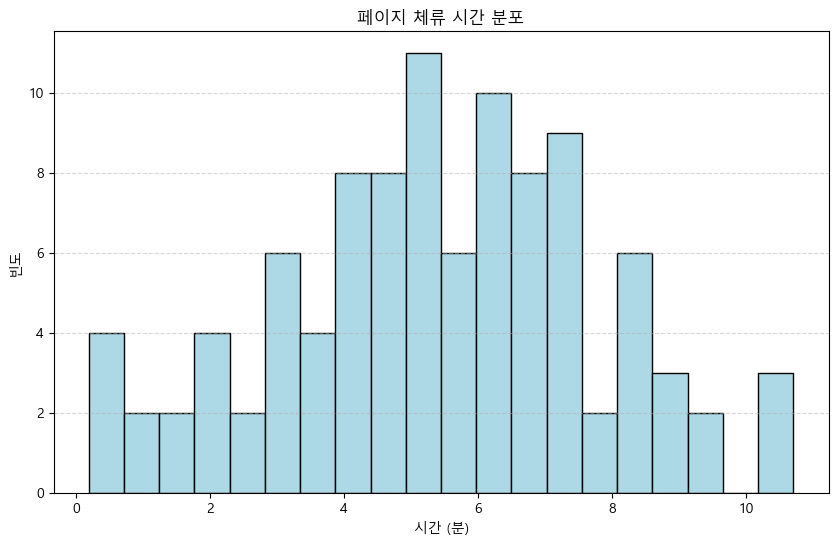

In [7]:
# 1. 페이지 체류 시간의 분포
plt.figure(figsize=(10, 6))
plt.hist(abtest_df['time_spent_on_the_page'], bins=20, edgecolor='black', color='lightblue')
plt.title('페이지 체류 시간 분포')
plt.xlabel('시간 (분)')
plt.ylabel('빈도')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.savefig('./savefig/페이지_체류시간_분포.png')

- 대부분의 사용자들은 페이지에 4분에서 8분 사이 머물고 있음

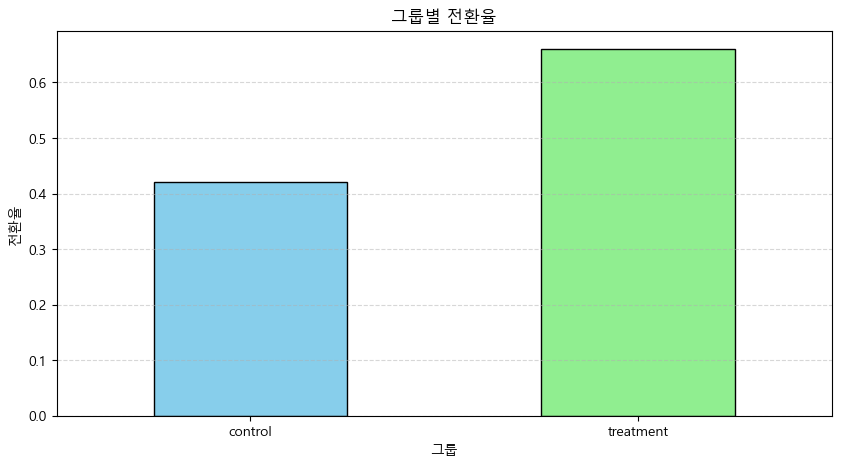

In [8]:
# 2. 그룹별 전환율
plt.figure(figsize=(10, 5))
abtest_df['converted'] = abtest_df['converted'].map({'yes': 1, 'no': 0})
group_conversion = abtest_df.groupby('group')['converted'].mean()
group_conversion.plot(kind='bar', color=['skyblue', 'lightgreen'], edgecolor='black')
plt.title('그룹별 전환율')
plt.xlabel('그룹')
plt.ylabel('전환율')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.savefig('./savefig/그룹별_전환율.png')

- 실험군(Treatment) 그룹이 대조군(Control) 그룹보다 약간 높은 전환율을 보임

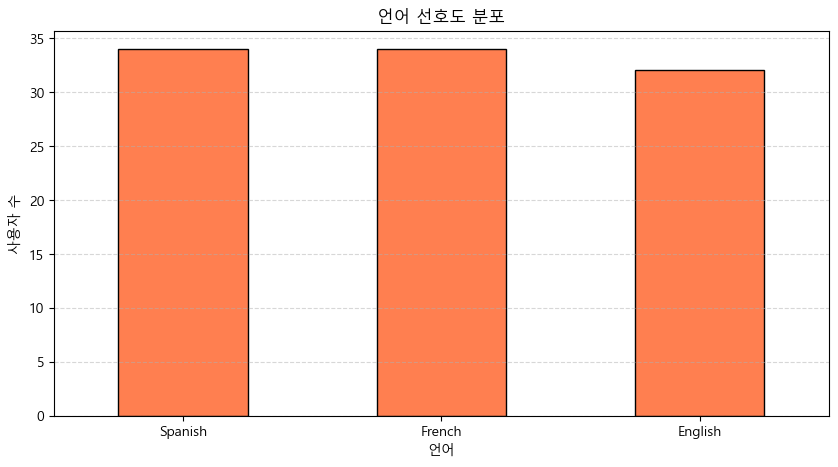

In [9]:
# 3. 언어 선호도 분포
plt.figure(figsize=(10, 5))
language_distribution = abtest_df['language_preferred'].value_counts()
language_distribution.plot(kind='bar', color='coral', edgecolor='black')
plt.title('언어 선호도 분포')
plt.xlabel('언어')
plt.ylabel('사용자 수')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.savefig('./savefig/언어_선호도_분포.png')

- 사용자의 언어 선호도는 거의 균등하게 분포되어 있음

---

## A/B Test 및 통계적 분석

### 1. 평균 페이지 체류 시간 차이 검정
독립표본 t-검정(Independent Sample t-test)

- **귀무 가설(H0)**: 두 그룹의 평균 페이지 체류 시간 차이가 없다.
- **대립 가설(H1)**: 두 그룹의 평균 페이지 체류 시간 차이가 있다.

In [10]:
from scipy.stats import ttest_ind

# Control 그룹과 Treatment 그룹의 페이지 체류 시간
control_time = abtest_df[abtest_df['group'] == 'control']['time_spent_on_the_page']
treatment_time = abtest_df[abtest_df['group'] == 'treatment']['time_spent_on_the_page']

# 독립표본 t-검정 수행
t_stat, p_value = ttest_ind(control_time, treatment_time)

# 결과 출력
print("t-통계량:", t_stat)
print("p-값:", p_value)

# 유의수준 0.05 하에서 유의미한 차이가 있는지 판단
if p_value < 0.05:
    print("두 그룹 간 평균 페이지 체류 시간에 유의미한 차이가 있음")
else:
    print("두 그룹 간 평균 페이지 체류 시간에 유의미한 차이가 없음")

t-통계량: -3.7867702694199856
p-값: 0.000263224705619001
두 그룹 간 평균 페이지 체류 시간에 유의미한 차이가 있음


In [11]:
# 평균 페이지 체류 시간 확인
print("대조군 평균 페이지 체류 시간:", round(control_time.mean(), 2))
print("실험군 평균 페이지 체류 시간:", round(treatment_time.mean(), 2))

대조군 평균 페이지 체류 시간: 4.53
실험군 평균 페이지 체류 시간: 6.22


- 실험군의 페이지 체류 시간이 대조군보다 약 37.31% 더 길어졌음
- 이는 새로운 랜딩 페이지가 사용자 참여도를 높이는 데 효과적일 가능성이 있음

### 2. 전환율 차이 검정
카이제곱 검정(Chi-square Test)

- **귀무 가설(H0)**: 두 그룹의 전환율 차이가 없다.
- **대립 가설(H1)**: 두 그룹의 전환율 차이가 있다.

In [12]:
from scipy.stats import chi2_contingency

# 컨트롤 그룹과 트리트먼트 그룹의 전환 여부 테이블 생성
conversion_table = pd.crosstab(abtest_df['group'], abtest_df['converted'])

# 카이제곱 검정 수행
chi2, p, dof, expected = chi2_contingency(conversion_table)

# 결과 출력
print("카이제곱 통계량:", chi2)
print("p-값:", p)

# 유의수준 0.05 하에서 유의미한 차이가 있는지 판단
if p < 0.05:
    print("두 그룹 간에 전환율의 유의미한 차이가 있음")
else:
    print("두 그룹 간에 전환율의 유의미한 차이가 없음")

카이제곱 통계량: 4.871175523349437
p-값: 0.02730889175492232
두 그룹 간에 전환율의 유의미한 차이가 있음


In [13]:
# 그룹별 전환율 확인
abtest_df.groupby('group')['converted'].mean()

group
control      0.42
treatment    0.66
Name: converted, dtype: float64

- 실험군의 전환율이 대조군보다 약 57.14% 높아졌음
- 이는 새로운 랜딩 페이지가 사용자에게 더 나은 경험을 제공할 가능성이 있음

### 3. 언어 선호도에 따른 분석
3-1. ANOVA 분석: 언어에 따른 페이지 체류 시간

- **귀무 가설(H0)**: 사용자가 선호하는 언어에 따라 페이지 체류 시간 차이가 없다.
- **대립 가설(H1)**: 사용자가 선호하는 언어에 따라 페이지 체류 시간 차이가 있다.

In [14]:
from scipy.stats import f_oneway

# 언어별 페이지 체류 시간 그룹화
english_time = abtest_df[abtest_df['language_preferred'] == 'English']['time_spent_on_the_page']
spanish_time = abtest_df[abtest_df['language_preferred'] == 'Spanish']['time_spent_on_the_page']
french_time = abtest_df[abtest_df['language_preferred'] == 'French']['time_spent_on_the_page']

# ANOVA 검정 수행
anova_stat, anova_p_value = f_oneway(english_time, spanish_time, french_time)

# 결과 출력
print("ANOVA 통계량:", anova_stat)
print("p-값:", anova_p_value)

# 유의수준 0.05 하에서 유의미한 차이가 있는지 판단
if anova_p_value < 0.05:
    print("언어별 페이지 체류 시간에 유의미한 차이가 있음")
else:
    print("언어별 페이지 체류 시간에 유의미한 차이가 없음")

ANOVA 통계량: 0.14343439221240437
p-값: 0.8665610536012649
언어별 페이지 체류 시간에 유의미한 차이가 없음


In [15]:
# 언어별 평균 페이지 체류시간 확인
print(english_time.mean(), spanish_time.mean(), french_time.mean())

5.5590625 5.331764705882352 5.253235294117647


- 사용자가 선호하는 언어는 페이지 체류 시간에 크게 영항을 미치지 않는 것으로 보임

3-2. 카이제곱 검정: 언어에 따른 전환율

- **귀무 가설(H0)**: 사용자가 선호하는 언어에 따라 전환율 차이가 없다.
- **대립 가설(H1)**: 사용자가 선호하는 언어에 따라 전환율 차이가 있다.

In [16]:
# 언어별 전환 여부 테이블 생성
language_conversion_table = pd.crosstab(abtest_df['language_preferred'], abtest_df['converted'])

# 카이제곱 검정 수행
chi2_lang, p_lang, dof_lang, expected_lang = chi2_contingency(language_conversion_table)

# 결과 출력
print("카이제곱 통계량:", chi2_lang)
print("p-값:", p_lang)

# 유의수준 0.05 하에서 유의미한 차이가 있는지 판단
if p_lang < 0.05:
    print("언어별 전환율에 유의미한 차이가 있음")
else:
    print("언어별 전환율에 유의미한 차이가 없음")

카이제곱 통계량: 3.0930306905370832
p-값: 0.2129888748754345
언어별 전환율에 유의미한 차이가 없음


- 사용자가 선호하는 언어는 전환율에 크게 영향을 미치지 않는 것으로 보임
- 이는 언어적 측면보다 다른 요인이 사용자 행동에 더 큰 영향을 미칠 수 있음을 나타냄

### 4. 페이지 체류 시간과 전환 여부의 상관관계

피어슨 상관 계수(Pearson Correlation Coefficient) 확인

- **귀무 가설(H0)**: 페이지 체류 시간과 전환율 사이에 상관관계가 없다.
- **대립 가설(H1)**: 페이지 체류 시간과 전환율 사이에 상관관계가 있다.

In [17]:
from scipy.stats import pearsonr

# 페이지에 체류 시간과 전환 여부의 상관관계 분석
correlation, p_value_corr = pearsonr(abtest_df['time_spent_on_the_page'], abtest_df['converted'])

# 결과 출력
print("상관계수:", correlation)
print("p-값:", p_value_corr)

# 유의수준 0.05 하에서 상관관계가 유의미한지 판단
if p_value_corr < 0.05:
    print("페이지 체류 시간과 전환 여부 간의 유의미한 상관관계가 있음")
else:
    print("페이지 체류 시간과 전환 여부 간의 유의미한 상관관계가 없음")

상관계수: 0.5702285607656761
p-값: 5.907378187464741e-10
페이지 체류 시간과 전환 여부 간의 유의미한 상관관계가 있음


- 페이지 체류 시간과 전환율은 양의 상관관계가 있으며, 페이지 체류 시간이 길수록 전환 가능성이 높음

---

## 결론

- 실험군이 대조군보다 더 높은 페이지 체류 시간과 전환율을 보였으며, 새로운 랜딩 페이지는 사용자 참여도와 전환율을 개선하는 데 긍정적인 영향을 끼쳤음을 나타냄
- 페이지 체류 시간은 전환율에 중요한 요인으로 작용하며, 사용자 경험을 향상시키고 페이지 체류 시간을 늘릴 전략을 고려해야 함
- 언어 선호도는 페이지 체류 시간과 전환율에 유의미한 영향을 미치지 않는 것으로 나타났으며, 이는 언어적 측면보다 다른 요인이 사용자 행동에 더 큰 영향을 미칠 수 있음을 시사함

이 결론을 바탕으로, 새로운 랜딩 페이지를 발전시키기 위해서는 페이지 체류 시간과 사용자 경험을 최적화할 수 있는 다양한 방안을 모색해야 한다. 사용자들이 페이지에 머무는 시간이 길어질수록 회사에 대한 신뢰도가 높아지고, 전환율 상승으로 이어질 가능성이 크다. 따라서, 직관적인 디자인과 빠른 로딩 속도, 사용자 친화적인 인터페이스를 통해 긍정적인 사용자 경험을 제공해야 한다.

또한, 전환율에 영향을 미치는 다른 요인들도 분석할 필요가 있다. 이를 통해 사용자 행동 패턴과 선호도를 이해하고, 이를 바탕으로 맞춤형 전략을 개발할 수 있다.

#### 전략 제안

1. 페이지 체류 시간 증가 전략
- 콘텐츠 강화: 유익하고 흥미로운 콘텐츠를 제공하여 사용자가 더 오래 머무르게 한다. 심층 분석 기사, 인터뷰, 독점 기사 등을 추가하여 관심을 끌어 모은다.
- 추천 콘텐츠: 사용자가 관심을 가질 만한 관련 뉴스 기사나 주제를 추천하여 페이지 체류 시간을 늘리고 구독 전환 가능성을 높인다.

2. 사용자 경험 최적화
- 빠른 로딩 속도: 페이지 로딩 속도를 최적화하여 사용자 이탈을 방지한다.
- 직관적 디자인: 주요 정보와 구독 유도 버튼을 눈에 잘 띄게 배치하고, 직관적인 디자인을 채택하여 사용자가 쉽게 탐색할 수 있도록 한다.